In [1]:
import os
import random
import numpy as np
import torch
import evaluate
import json
from sentence_transformers import SentenceTransformer

# Please make sure you are using CUDA enabled GPU for this project
device = 'cuda'

# Setting the seed value ensures that the results are reproducible across different runs
seed_val = 10

# Ensuring that the seed is set for Python's hashing, random operations, NumPy, and PyTorch
os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

In [2]:
model = SentenceTransformer("all-mpnet-base-v2")

In [3]:
responses = json.loads(open("data/cleaned_generations_20.json").read())

In [4]:
# Using Rouge to evaluate syntactic similarity for our datasets (coQA)
rouge_metric = evaluate.load('rouge')

result_dict = {}

sentence_transformer_predictions = []

predictions = []

In [8]:
from tqdm import tqdm

for sample_idx in tqdm(responses):
    sample = responses[sample_idx]
    # Getting data from the sample
    # Please run the cleaner notebook before running this code
    question_text = sample['prompt']
    generated_texts = sample['generations'] if 'cleaned_generations' not in sample else sample['cleaned_generations']
    sample_id = sample_idx
    unique_responses = list(set(generated_texts))

    # Variables for semantic similarity analysis
    answer_pairs_1 = []
    answer_pairs_2 = []
    has_semantically_different_answers = False
    syntactic_similarities = {rouge_type: 0.0 for rouge_type in ['rouge1', 'rouge2', 'rougeL']}
    semantic_set_ids = {answer: index for index, answer in enumerate(unique_responses)}

    # print('No of unique answers:', len(unique_responses))
    per_iter_sentence_transformers_predictions = []
    # Evalauate semantic similarity if there are more than 1 unique answers
    if len(unique_responses) > 1:
        for i, reference_answer in enumerate(unique_responses):
            for j in range(i + 1, len(unique_responses)):

                answer_pairs_1.append(unique_responses[i])
                answer_pairs_2.append(unique_responses[j])

                encoded_input_1 = model.encode(unique_responses[i], padding=True)
                encoded_input_2 = model.encode(unique_responses[j], padding=True)

                prediction = model.similarity(encoded_input_1, encoded_input_2)
                prediction = prediction.item()
                predictions.append(prediction)

                # Determine semantic similarity
                sentence_transformer_prediction = 0 if prediction < 0.5 else 1
                if sentence_transformer_prediction == 0:
                    has_semantically_different_answers = True
                else:
                    semantic_set_ids[unique_responses[j]] = semantic_set_ids[unique_responses[i]]

                sentence_transformer_predictions.append([unique_responses[i], unique_responses[j], sentence_transformer_prediction])
                per_iter_sentence_transformers_predictions.append([i, j, sentence_transformer_prediction])

        # Evalauate syntactic similarity
        results = rouge_metric.compute(predictions=answer_pairs_1, references=answer_pairs_2)
        for rouge_type in syntactic_similarities.keys():
            syntactic_similarities[rouge_type] = results[rouge_type]
    
    # Store the results in the result dictionary
    result_dict[sample_id] = {
        'syntactic_similarities': syntactic_similarities,
        'has_semantically_different_answers': has_semantically_different_answers,
        'semantic_set_ids': [semantic_set_ids[x] for x in generated_texts],
        'deberta_predictions': per_iter_sentence_transformers_predictions
    }

100%|██████████| 817/817 [01:36<00:00,  8.47it/s]


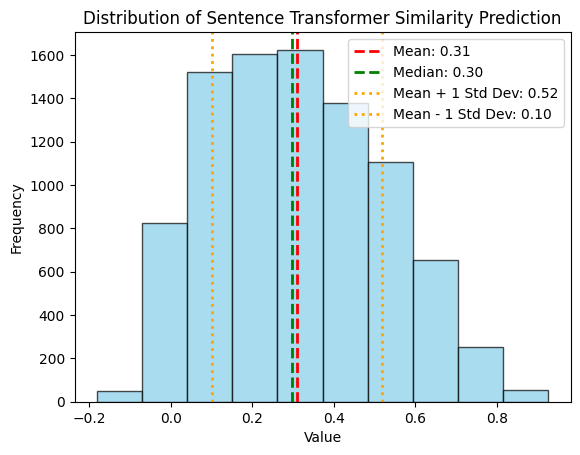

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean and median
mean = np.mean(predictions)
median = np.median(predictions)
std_dev = np.std(predictions)


# Plot histogram
plt.hist(predictions, bins=10, color='skyblue', edgecolor='black', alpha=0.7)

# Add vertical lines for mean and median
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
plt.axvline(mean + std_dev, color='orange', linestyle='dotted', linewidth=2, label=f'Mean + 1 Std Dev: {mean + std_dev:.2f}')
plt.axvline(mean - std_dev, color='orange', linestyle='dotted', linewidth=2, label=f'Mean - 1 Std Dev: {mean - std_dev:.2f}')


# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Transformer Similarity Prediction')

# Show legend
plt.legend()

# Show plot
plt.show()


In [10]:
import csv 

with open('data/sentence_transformer_predictions_20.csv', "w", encoding="UTF8") as f:
    writer = csv.writer(f)
    
    # Writing header row and deberta predictions for the CSV file
    writer.writerow(['qa_1', 'qa_2', 'prediction'])
    writer.writerows(sentence_transformer_predictions)

In [11]:
len(sentence_transformer_predictions)

9080

In [12]:
import pickle

with open ('data/similarity_scores_sentence_transformer_20.json', "w") as f:
    f.write(json.dumps(result_dict))
with open(f'data/similarity_scores_sentence_transformers_20.pkl','wb') as outfile:
    pickle.dump(result_dict, outfile)